In [1]:
import sys
print(sys.version)
print(sys.path)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
['/Users/tokudo/opt/anaconda3/envs/grips/lib/python36.zip', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/lib-dynload', '', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/aeosa', '/Users/tokudo/Develop/grips/grina', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/IPython/extensions', '/Users/tokudo/.ipython']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

df["Valuation($B) flaot"] = df["Valuation($B)"].apply(trans2float)

In [5]:
df["Valuation($B) flaot"].describe()

count    501.000000
mean       3.185749
std        7.676841
min        1.000000
25%        1.000000
50%        1.500000
75%        3.000000
max      140.000000
Name: Valuation($B) flaot, dtype: float64

In [6]:
df["DateTime Joined"] = df["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [7]:
df.head()

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [8]:
def clean(element):
    return element.strip()

In [9]:
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Didi Chuxing
Bitmain Technologies
Grab
Tokopedia


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,100credit,Sequoia Capital China
1,100credit,China Reform Fund
2,100credit,Hillhouse Capital Management
3,17zuoye,DST Global
4,17zuoye,Temasek Holdings
...,...,...
1380,Zwift,True
1381,Zwift,Causeway Media Partners
1382,Zymergen,Data Collective
1383,Zymergen,True Ventures


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
y
Done!!


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation($B),Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
1,China Reform Fund,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
2,Hillhouse Capital Management,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
3,DST Global,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07
4,Temasek Holdings,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Industry": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                Country  \
                                    sum count  mean <lambda_0>   
0       01 Advisors                2.00     1  2.00          1   
1      500 Startups                4.50     2  2.25          2   
2            58.com                3.00     2  1.50          1   
3        5Y Capital                1.22     1  1.22          1   
4           83North               11.55     5  2.31          3   
..              ...                 ...   ...   ...        ...   
690         iFLYTEK                1.00     1  1.00          1   
691  iNovia Capital                1.04     1  1.04          1   
692   iTech Capital                1.00     1  1.00          1   
693  index Ventures                5.50     1  5.50          1   
694          next47                1.60     1  1.60          1   

                                        Industry  \
                                  set <lambda_0>   
0                     {United States}          1   
1            {Indonesia, Philippines}          2   
2                             {China}          1   
3                             {China}          1   
4    {United States, France, Germany}          4   
..                                ...        ...   
690                           {China}          1   
691                   {United States}          1   
692                     {Netherlands}          1   
693                  {United Kingdom}          1   
694                   {United States}          1   

                                                          Company  \
                                                   set <lambda_0>   
0                                            {Fintech}          1   
1             {Other, E-commerce & direct-to-consumer}          2   
2                    {E-commerce & direct-to-consumer}          2   
3                        {Mobile & telecommunications}          1   
4    {Data management & analytics, Fintech, Auto & ...          5   
..                                                 ...        ...   
690                                         {Hardware}          1   
691                  {E-commerce & direct-to-consumer}          1   
692                                         {Hardware}          1   
693                                          {Fintech}          1   
694                                    {Cybersecurity}          1   

                                                       DateTime Joined  
                                                   set             min  
0                                            {Tipalti}      2020-10-06  
1                   {Revolution Precrafted, Bukalapak}      2017-10-23  
2                            {Tubatu.com, Zhuan Zhuan}      2015-03-09  
3                                        {GalaxySpace}      2020-11-17  
4    {Marqeta, Via Transportation, Mirakl, Celonis,...      2017-12-05  
..                                                 ...             ...  
690                              {TERMINUS Technology}      2018-10-25  
691                                        {AppDirect}      2015-10-07  
692                                          {BitFury}      2018-11-06  
693                                          {Revolut}      2018-04-26  
694                                          {Verkada}      2020-01-29  

[695 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,01 Advisors,2.00,1,2.00,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06
1,500 Startups,4.50,2,2.25,2,"{Indonesia, Philippines}",2,"{Other, E-commerce & direct-to-consumer}",2,"{Revolution Precrafted, Bukalapak}",2017-10-23
2,58.com,3.00,2,1.50,1,{China},1,{E-commerce & direct-to-consumer},2,"{Tubatu.com, Zhuan Zhuan}",2015-03-09
3,5Y Capital,1.22,1,1.22,1,{China},1,{Mobile & telecommunications},1,{GalaxySpace},2020-11-17
4,83North,11.55,5,2.31,3,"{United States, France, Germany}",4,"{Data management & analytics, Fintech, Auto & ...",5,"{Marqeta, Via Transportation, Mirakl, Celonis,...",2017-12-05


In [23]:
analysis_invest_df.to_csv(os.path.join("..", "out", "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Star VC,0.004323,0.000000,1.497785e-02,0.195880,0.001067,7.50,1,7.500000,1,{China},1,{Artificial intelligence},1,{SenseTime},2017-07-11
1,TLV Partners,0.002882,0.000000,5.797968e-03,0.172765,0.000764,2.00,1,2.000000,1,{United States},1,{Fintech},1,{Next Insurance},2019-10-07
2,Breyer Capital,0.005764,0.000695,2.369982e-02,0.201575,0.001286,4.30,2,2.150000,1,{United States},2,"{Artificial intelligence, Internet software & ...",2,"{Grammarly, C3.ai}",2017-03-02
3,Lightspeed Venture Partners,0.027378,0.019544,1.503328e-01,0.253428,0.005090,33.95,12,2.829167,2,"{United States, India}",8,"{Supply chain, logistics, & delivery, Health, ...",12,"{TripActions, Orca Bio, Seismic, Aurora, Rubri...",2015-04-14
4,A&NN,0.001441,0.000000,1.583809e-20,0.001441,0.001475,1.00,1,1.000000,1,{Luxembourg},1,{Other},1,{OCSiAl},2019-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Passion Capital,0.002882,0.000000,4.298099e-03,0.164933,0.000786,1.58,1,1.580000,1,{United Kingdom},1,{Fintech},1,{Monzo},2018-10-31
691,WRVI Capital,0.002882,0.000000,5.710152e-03,0.177608,0.000867,1.00,1,1.000000,1,{United States},1,{Hardware},1,{Innovium},2020-07-21
692,Fidelity Investments,0.002882,0.000000,1.705775e-03,0.155182,0.001018,1.60,1,1.600000,1,{United States},1,{Consumer & retail},1,{sweetgreen},2018-11-13
693,Invesco Perpetual,0.002882,0.000000,1.777468e-16,0.002882,0.001475,2.23,1,2.230000,1,{United Kingdom},1,{Health},1,{Oxford Nanopore Technologies},2015-07-21


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,Meero,0.006,0.000455,2.133068e-04,0.219058,0.001041,$1,6/18/2019,France,Artificial intelligence,"[Aglae Ventures, Global Founders Capital, Al...",1.0,2019-06-18
1,Kuaishou,0.062,0.013075,3.170122e-02,0.328691,0.003548,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.0,2015-01-01
2,Greensill,0.062,0.002554,2.392629e-02,0.323772,0.003419,$4,7/16/2018,United Kingdom,Fintech,"[SoftBank Group, General Atlantic]",4.0,2018-07-16
3,HyalRoute,0.000,0.000000,1.490423e-107,0.000000,0.000346,$3.50,5/26/2020,Singapore,Mobile & telecommunications,[Kuang-Chi],3.5,2020-05-26
4,OCSiAl,0.000,0.000000,1.490423e-107,0.000000,0.000346,$1,3/4/2019,Luxembourg,Other,"[A&NN, Rusnano]",1.0,2019-03-04


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 11.80%
投資家コンポーネント上位10件のサイズ
[506   7   4   3   3   3   3   3   3   3]
ネットワーク密度: 0.85%


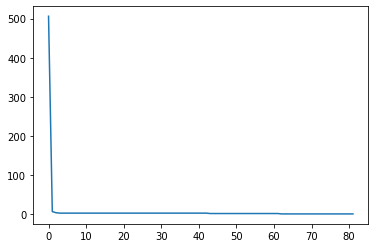

In [28]:
describe_components(investor_graph)

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 16.37%
投資家コンポーネント上位10件のサイズ
[417   3   2   1   1   1   1   1   1   1]
ネットワーク密度: 4.16%


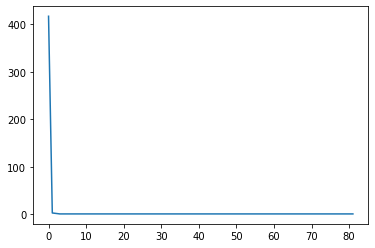

In [29]:
describe_components(company_graph)

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [30]:
df.sort_values(by=["Date Joined"])

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
255,LinkSure Network,$1,1/1/2015,China,Mobile & telecommunications,[N/A],1.00,2015-01-01
242,Kuaishou,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.00,2015-01-01
244,L&P Cosmetic,$1.19,1/1/2016,South Korea,Consumer & retail,[CDIB Capital],1.19,2016-01-01
418,Traveloka,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.00,2017-01-01
24,AppLovin,$2,1/1/2017,United States,Mobile & telecommunications,"[Orient Hontai Capital, Webb Investment Network]",2.00,2017-01-01
...,...,...,...,...,...,...,...,...
275,Mia.com,$1,9/8/2015,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, ZhenFund, K2 Ventures]",1.00,2015-09-08
302,OfferUp,$1.20,9/8/2016,United States,Mobile & telecommunications,"[Andreessen Horowitz, GGV Capital, T. Rowe P...",1.20,2016-09-08
280,Mollie,$1,9/8/2020,Netherlands,Fintech,[Technology Crossover Ventures],1.00,2020-09-08
460,WEMAKEPRICE,$2.34,9/9/2015,South Korea,E-commerce & direct-to-consumer,"[IMM Investment, NXC]",2.34,2015-09-09


In [31]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [32]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,2.954321,717.90,1.0,46.00,243.0
China,4.379661,516.80,1.0,140.00,118.0
India,3.510400,87.76,1.0,16.00,25.0
United Kingdom,2.728750,65.49,1.0,11.08,24.0
South Korea,2.761818,30.38,1.0,9.00,11.0


In [33]:
industry_group = df.groupby("Industry").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Industry,,,,,
Fintech,3.513099,249.43,1.0,36.0,71.0
Artificial intelligence,5.386444,242.39,1.0,140.0,45.0
E-commerce & direct-to-consumer,2.683594,171.75,1.0,15.0,64.0
Auto & transportation,4.915357,137.63,1.0,62.0,28.0
Internet software & services,2.047656,131.05,1.0,6.0,64.0


In [34]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

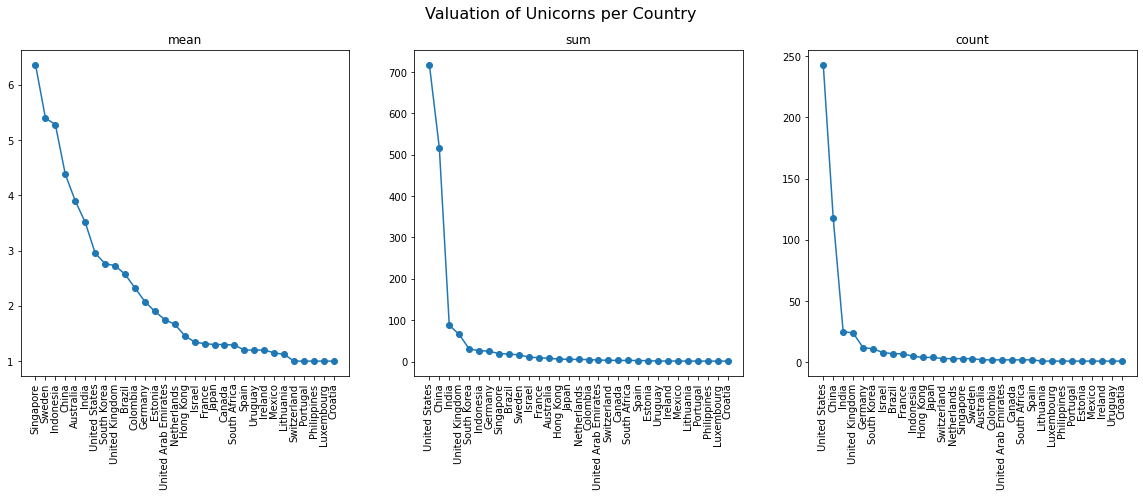

Complete output to ../out/features/value_per_country.png


In [35]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

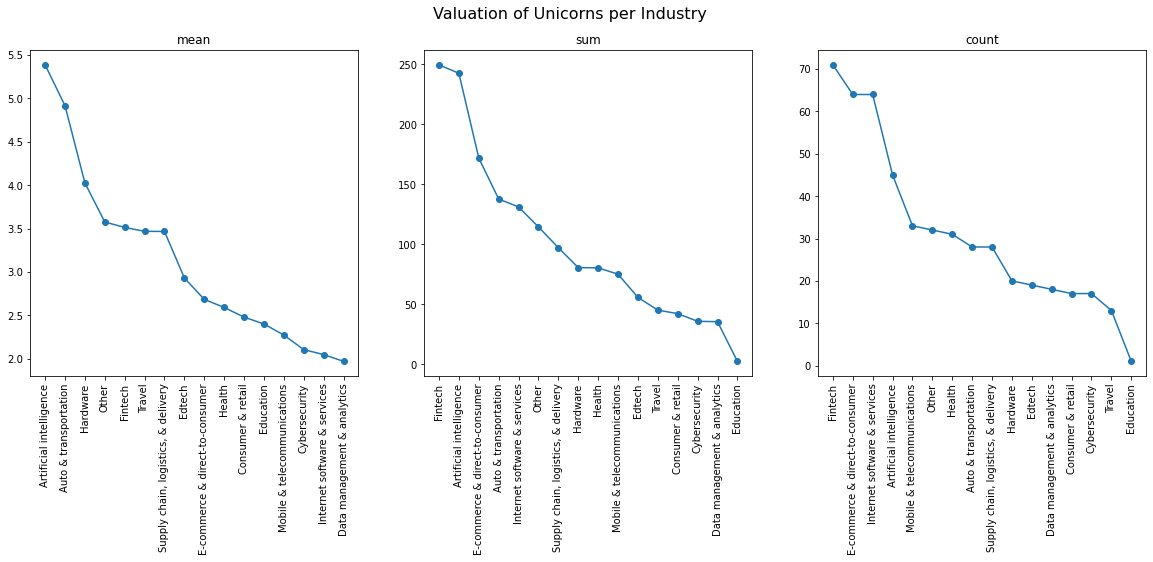

Complete output to ../out/features/value_per_industry.png


In [36]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [37]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

501


,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2018-04-18,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00
2018-03-07,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00
2015-07-03,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50
2018-12-19,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00
2015-10-12,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00
...,...,...,...,...,...,...,...
2015-04-10,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60
2018-11-01,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25
2018-07-18,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00


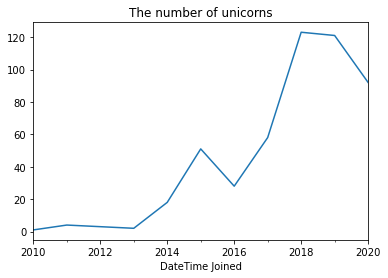

In [38]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join("..", "out", "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [39]:
company_graph_pd

,source,target
0,Meero,Dataiku
1,Meero,Away
2,Meero,Traveloka
3,Kuaishou,Bird Rides
4,Kuaishou,Klarna
...,...,...
3605,Jusfoun Big Data,Bitmain Technologies
3606,FXiaoKe,Womai
3607,FXiaoKe,Bitmain Technologies
3608,Bitmain Technologies,Womai


In [40]:
uc_date = df[["Company", "Date Joined", "Country", "Industry", "Valuation($B) flaot"]]
datetime_s = uc_date["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
uc_date["DateTime Joined"] = datetime_s
uc_date = uc_date.set_index("Company")
elem_dict = uc_date.to_dict("index")

/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
uc_date.head()

,Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
Company,,,,,
100credit,4/18/2018,China,Fintech,1.0,2018-04-18
17zuoye,3/7/2018,China,Edtech,1.0,2018-03-07
23andMe,7/3/2015,United States,Health,2.5,2015-07-03
4Paradigm,12/19/2018,China,Artificial intelligence,2.0,2018-12-19
58 Daojia,10/12/2015,China,Internet software & services,1.0,2015-10-12


In [42]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Meero,Dataiku
1,Away,Meero
2,Traveloka,Meero
3,Kuaishou,Bird Rides
4,Klarna,Kuaishou
...,...,...
3605,Bitmain Technologies,Jusfoun Big Data
3606,FXiaoKe,Womai
3607,FXiaoKe,Bitmain Technologies
3608,Womai,Bitmain Technologies


In [43]:
# チェック用
print(elem_dict["Flexport"]["Date Joined"])
print(elem_dict["Knotel"]["Date Joined"])
print(elem_dict["Gong"]["Date Joined"])
print(elem_dict["VAST Data"]["Date Joined"])
print(elem_dict["Dave"]["Date Joined"])
print(elem_dict["Udemy"]["Date Joined"])

4/30/2018
8/21/2019
8/12/2020
4/16/2020
9/30/2019
2/19/2020


In [44]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [45]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Industry"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Industry"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [46]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [47]:
val_size[:10]

[100.0,
 102.58992805755396,
 102.58992805755396,
 112.94964028776978,
 210.07194244604318,
 111.5251798561151,
 162.4820143884892,
 105.76258992805755,
 109.71223021582733,
 109.71223021582733]

In [48]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join("..", "out", "sen2jun_dgraph"))

In [49]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [50]:
comp_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [51]:
investor_graph_pd

,source,target
0,Star VC,IDG Capital
1,Star VC,Infore Capital
2,Star VC,Alibaba Group
3,TLV Partners,Ribbit Capital
4,TLV Partners,Zeev Ventures
...,...,...
1235,L Catterton,Acequia Capital
1236,Kleiner Perkins Caufield & Byers,American Express Ventures
1237,Goldman Sachs,Insights Venture Partners
1238,Goldman Sachs,Norwest Venture Partners


In [52]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [53]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,IDG Capital,Star VC
1,Star VC,Infore Capital
2,Alibaba Group,Star VC
3,Ribbit Capital,TLV Partners
4,Zeev Ventures,TLV Partners
...,...,...
1235,L Catterton,Acequia Capital
1236,Kleiner Perkins Caufield & Byers,American Express Ventures
1237,Goldman Sachs,Insights Venture Partners
1238,Goldman Sachs,Norwest Venture Partners


In [54]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [55]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,IDG Capital,0.043027,0.001682,4.958935e-14,0.028142,0.002494,0.013353,0.029674,6,70,...,63.68,17,3.745882,3,"{China, United States, Japan}",8,"{Edtech, Artificial intelligence, Mobile & tel...",17,"{TERMINUS Technology, Jusfoun Big Data, Kujial...",2015-06-16
1,Star VC,0.004451,0.000000,1.315948e-12,0.020473,0.001011,0.002967,0.001484,1,1,...,7.50,1,7.500000,1,{China},1,{Artificial intelligence},1,{SenseTime},2017-07-11
2,Infore Capital,0.004451,0.000000,3.345124e-11,0.021277,0.001869,0.004451,0.000000,0,0,...,7.50,1,7.500000,1,{China},1,{Artificial intelligence},1,{SenseTime},2017-07-11
3,Alibaba Group,0.032641,0.000622,1.291628e-26,0.004276,0.000956,0.001484,0.031157,6,245,...,54.15,12,4.512500,4,"{China, Indonesia, India, United States}",10,"{Edtech, Supply chain, logistics, & delivery, ...",12,"{58 Daojia, DT Dream, One97 Communications, Ta...",2014-03-20
4,Ribbit Capital,0.013353,0.000751,7.448808e-06,0.037455,0.002696,0.007418,0.005935,2,7,...,12.70,5,2.540000,2,"{United States, United Kingdom}",1,{Fintech},5,"{Figure Technologies, Next Insurance, Revolut,...",2018-04-26


In [56]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [57]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.779538,-0.014058,0.218633,0.169704,0.649999,0.953418,0.560677,0.575646,NaN,NaN,1.000000,NaN,0.710327,0.989324,0.055185,0.762981,0.954295,0.989324
Betweenness Centrality,0.779538,1.000000,-0.009484,0.190790,0.215805,0.564489,0.720286,0.417125,0.398017,NaN,NaN,0.779538,NaN,0.625113,0.781806,0.031829,0.528600,0.680507,0.781806
Eigen Centrality,-0.014058,-0.009484,1.000000,0.075362,0.127148,0.006582,-0.019643,-0.028718,-0.014536,NaN,NaN,-0.014058,NaN,-0.012046,-0.014521,-0.006716,-0.013831,-0.016164,-0.014521
Closeness Centrality,0.218633,0.190790,0.075362,1.000000,0.324360,0.589774,0.030751,-0.123460,-0.144113,NaN,NaN,0.218633,NaN,0.085941,0.194517,0.007869,0.176553,0.190892,0.194517
Page Rank,0.169704,0.215805,0.127148,0.324360,1.000000,0.549216,-0.012424,-0.193961,-0.104319,NaN,NaN,0.169704,NaN,0.091140,0.154967,-0.008274,0.108168,0.131394,0.154967
In-degree Centrality,0.649999,0.564489,0.006582,0.589774,0.549216,1.000000,0.390485,0.138018,0.089572,NaN,NaN,0.649999,NaN,0.398449,0.624384,0.069031,0.495635,0.596323,0.624384
Out-degree Centrality,0.953418,0.720286,-0.019643,0.030751,-0.012424,0.390485,1.000000,0.624436,0.661801,NaN,NaN,0.953418,NaN,0.702350,0.950652,0.039452,0.727559,0.919356,0.950652
Elongation,0.560677,0.417125,-0.028718,-0.123460,-0.193961,0.138018,0.624436,1.000000,0.810844,NaN,NaN,0.560677,NaN,0.400352,0.556414,0.045120,0.437361,0.591764,0.556414
Expansion,0.575646,0.398017,-0.014536,-0.144113,-0.104319,0.089572,0.661801,0.810844,1.000000,NaN,NaN,0.575646,NaN,0.489686,0.573463,0.084846,0.414564,0.594008,0.573463
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


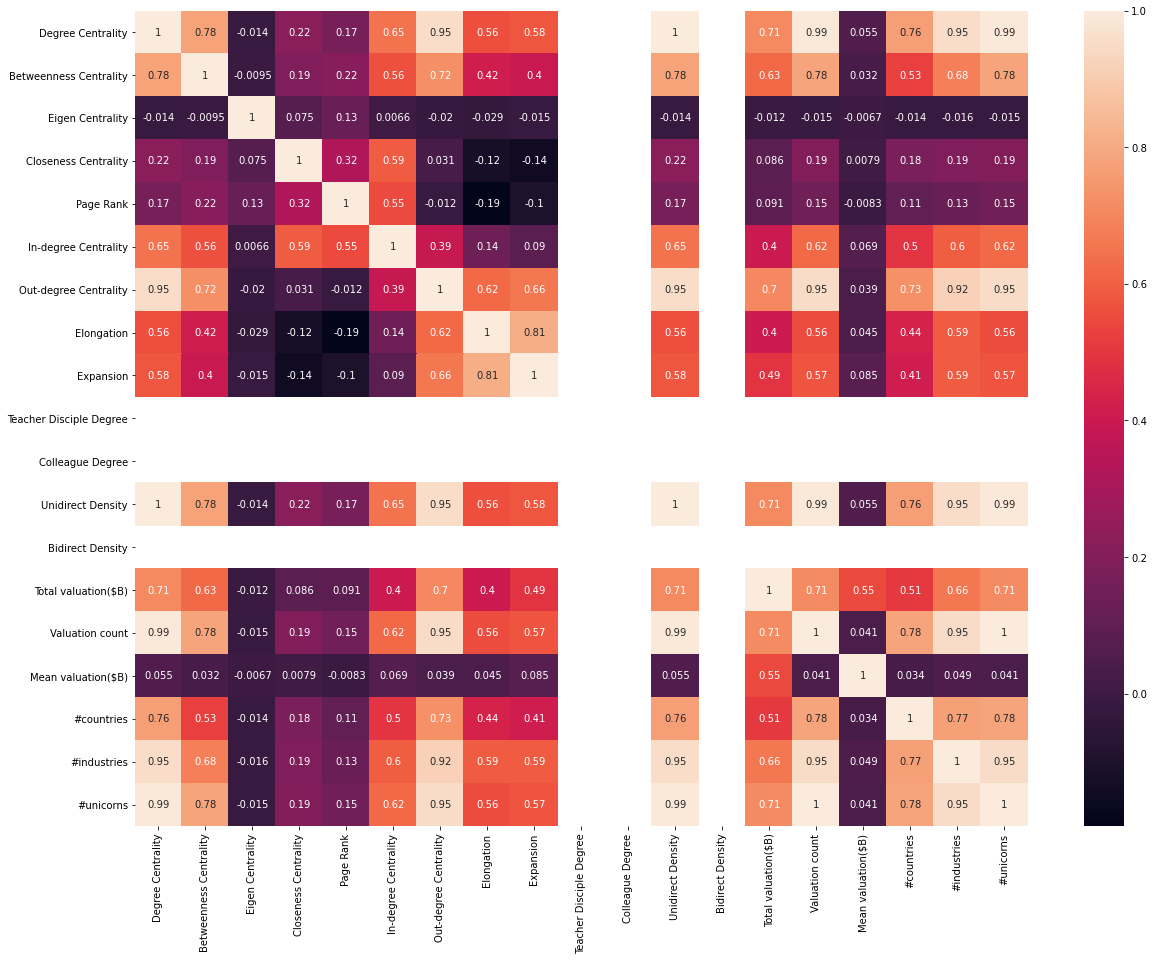

In [58]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "investor_correlation.png"))

In [59]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,100credit,1.0
1,17zuoye,1.0
2,23andMe,2.5
3,4Paradigm,2.0
4,58 Daojia,1.0


In [60]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [61]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Meero,0.007126,0.000386,2.550019e-34,0.032960,0.001649,0.004751,0.002375,4,7,1.0,...,0.003555,0.0,$1,6/18/2019,France,Artificial intelligence,"[Aglae Ventures, Global Founders Capital, Al...",1.0,2019-06-18,1.0
Dataiku,0.021378,0.000334,6.998816e-24,0.101094,0.002563,0.016627,0.004751,3,6,1.0,...,0.010664,0.0,$1.40,12/4/2019,United States,Internet software & services,"[Alven Capital, FirstMark Capital, capitalG]",1.4,2019-12-04,1.4
Away,0.019002,0.000752,1.026045e-35,0.042234,0.001719,0.011876,0.007126,5,15,1.0,...,0.009479,0.0,$1.40,5/15/2019,United States,E-commerce & direct-to-consumer,"[Global Founders Capital, Comcast Ventures, ...",1.4,2019-05-15,1.4
Traveloka,0.004751,0.000000,2.250281e-59,0.000000,0.000815,0.000000,0.004751,5,16,1.0,...,0.002370,0.0,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.0,2017-01-01,3.0
Kuaishou,0.073634,0.002263,1.057246e-48,0.014868,0.000923,0.011876,0.061758,6,270,1.0,...,0.036730,0.0,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.0,2015-01-01,18.0


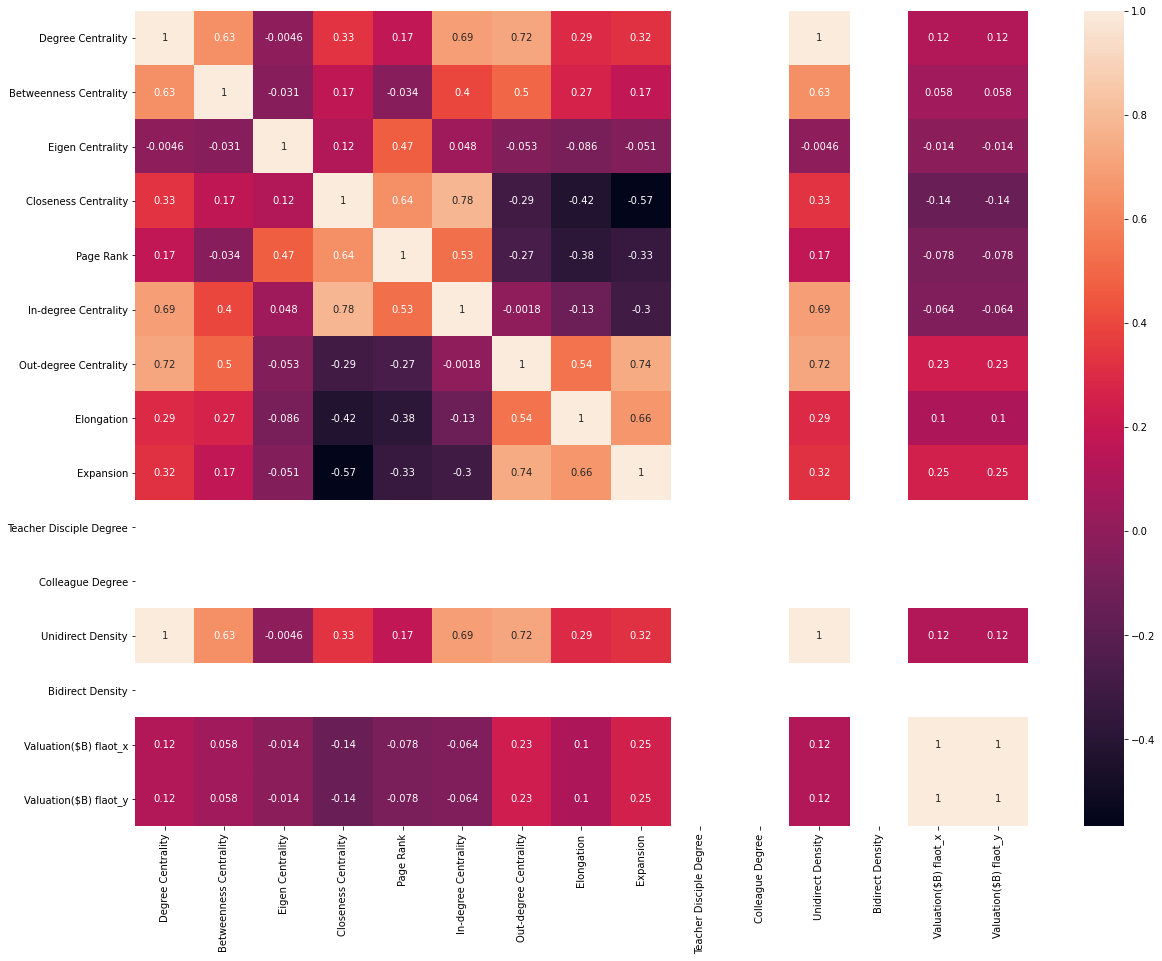

In [62]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

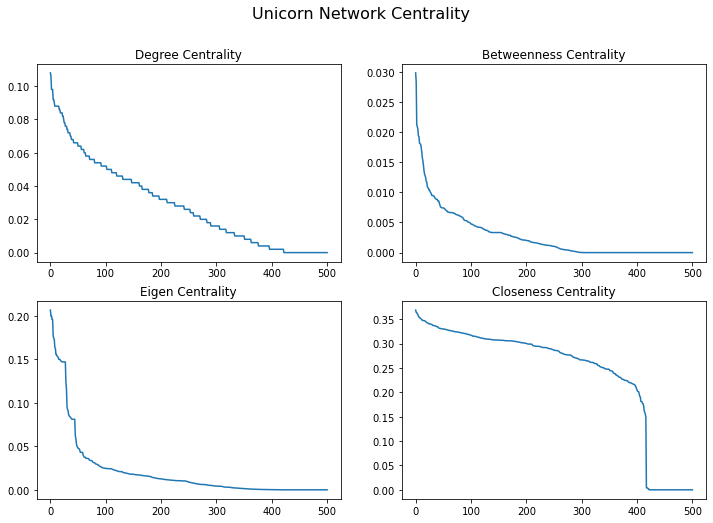

In [63]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "unicorn_network_centrality.png"))

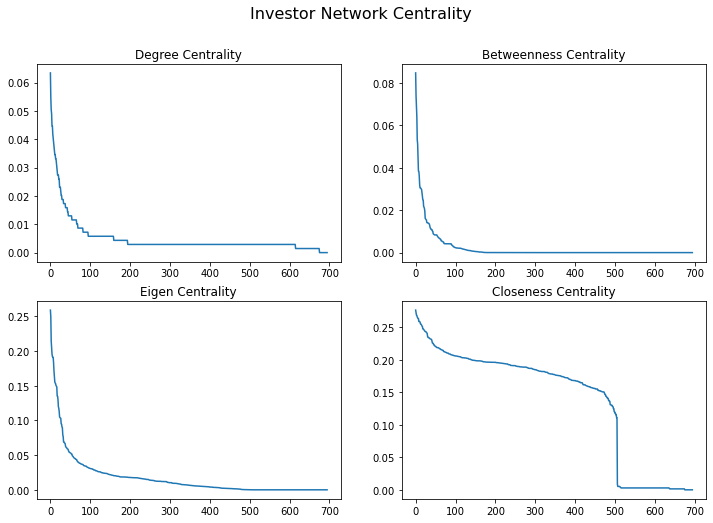

In [64]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "investor_network_centrality.png"))

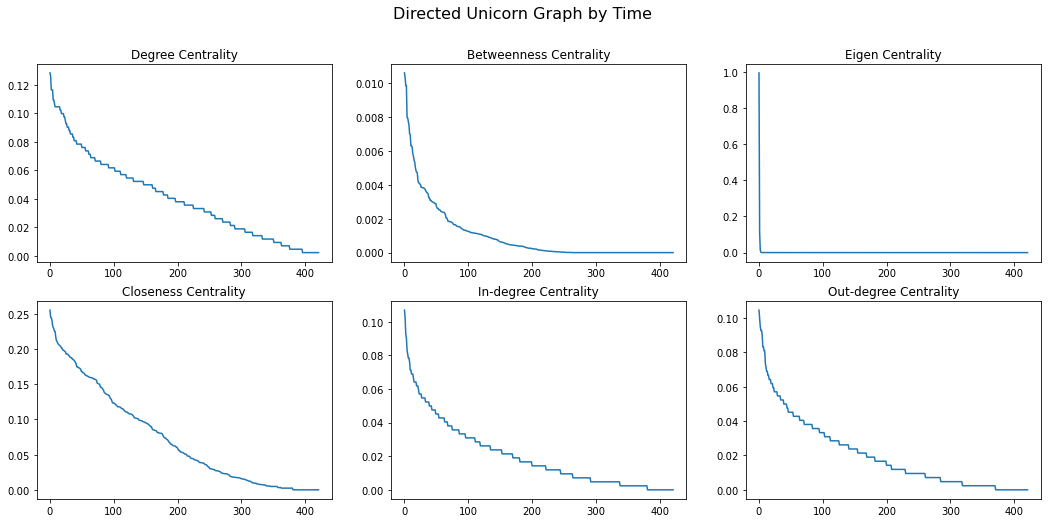

In [65]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "directed_unicorn_centrality.png"))

# データの出力

In [66]:
investor_centrality_df.to_csv(os.path.join("..", "out", "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join("..", "out", "features", "unicorn_centrality.csv"))

In [67]:
unicorn_data_df.corr().to_csv(os.path.join("..", "out", "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join("..", "out", "features", "investor_correlation.csv"))

## 企業 - 国・産業ネットワーク

In [68]:
df

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00,2015-10-12
...,...,...,...,...,...,...,...,...
496,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60,2015-04-10
497,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25,2018-11-01
498,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00,2018-07-18
499,Zwift,$1,9/16/2020,United States,E-commerce & direct-to-consumer,"[Novator Partners, True, Causeway Media Part...",1.00,2020-09-16


In [69]:
country_industry_df = pd.merge(comp_dgraph_df, df[["Company", "Country", "Industry", "DateTime Joined"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Industry", "DateTime Joined"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()
country_industry_df.to_csv(os.path.join("..", "out", "edgelist", "country_industry_dgraph.csv"))

In [70]:
country_dgraph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_dgraph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_graph.csv"))

In [71]:
country_graph_matrix.max().max()

1364.0

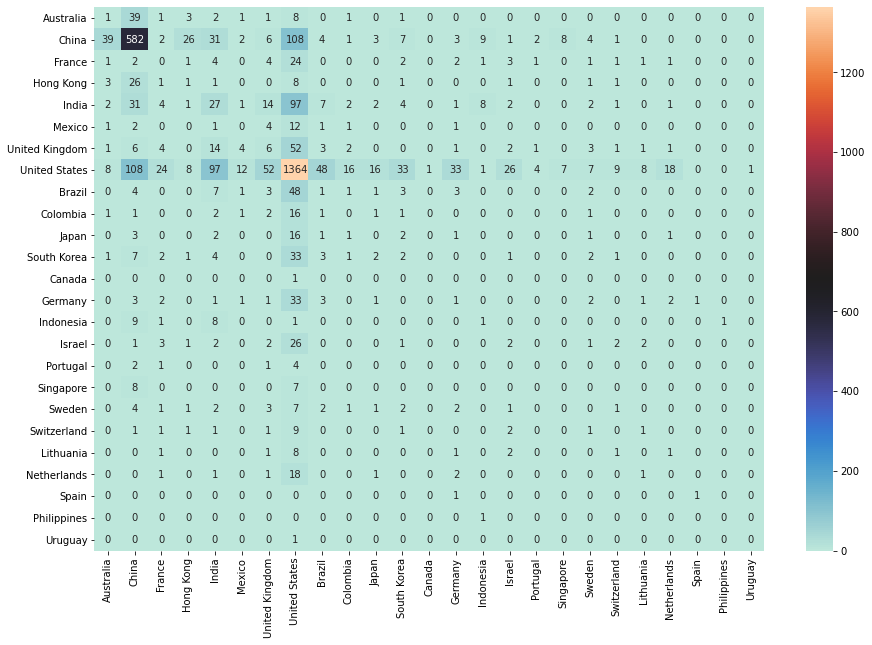

In [72]:
plt.figure(figsize=(15, 10))
center = (country_graph_matrix.max().max() - country_graph_matrix.min().min()) / 2
sns.heatmap(country_graph_matrix, center=center, annot=True, fmt=".0f")
plt.savefig(os.path.join("..", "out", "adjacency", "country_graph.png"))

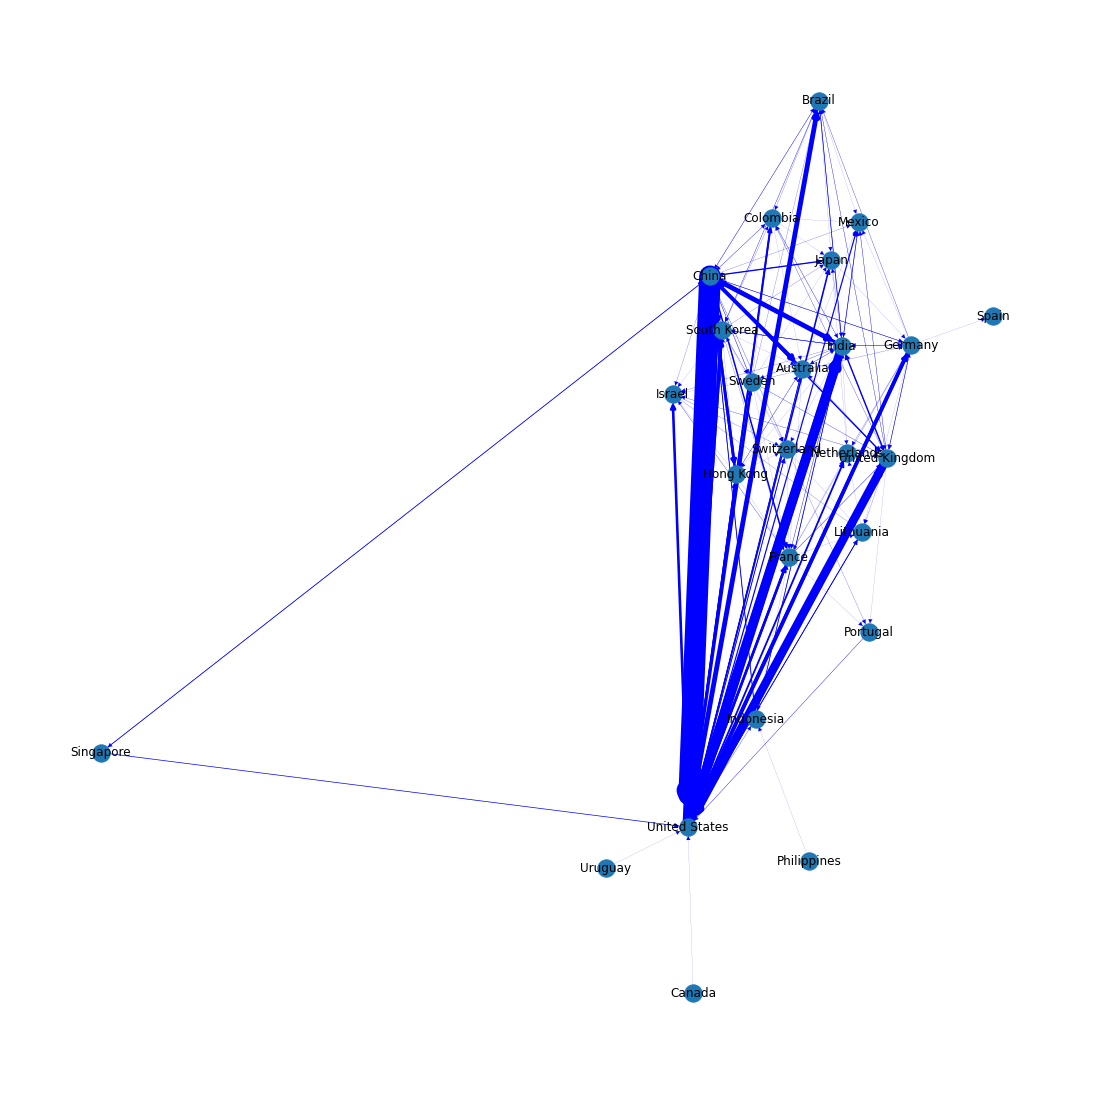

In [73]:
country_DG = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "country_dgraph.png"))
country_dgraph_df.to_csv(os.path.join("..", "out", "edgelist", "country_dgraph.csv"), sep="\t")

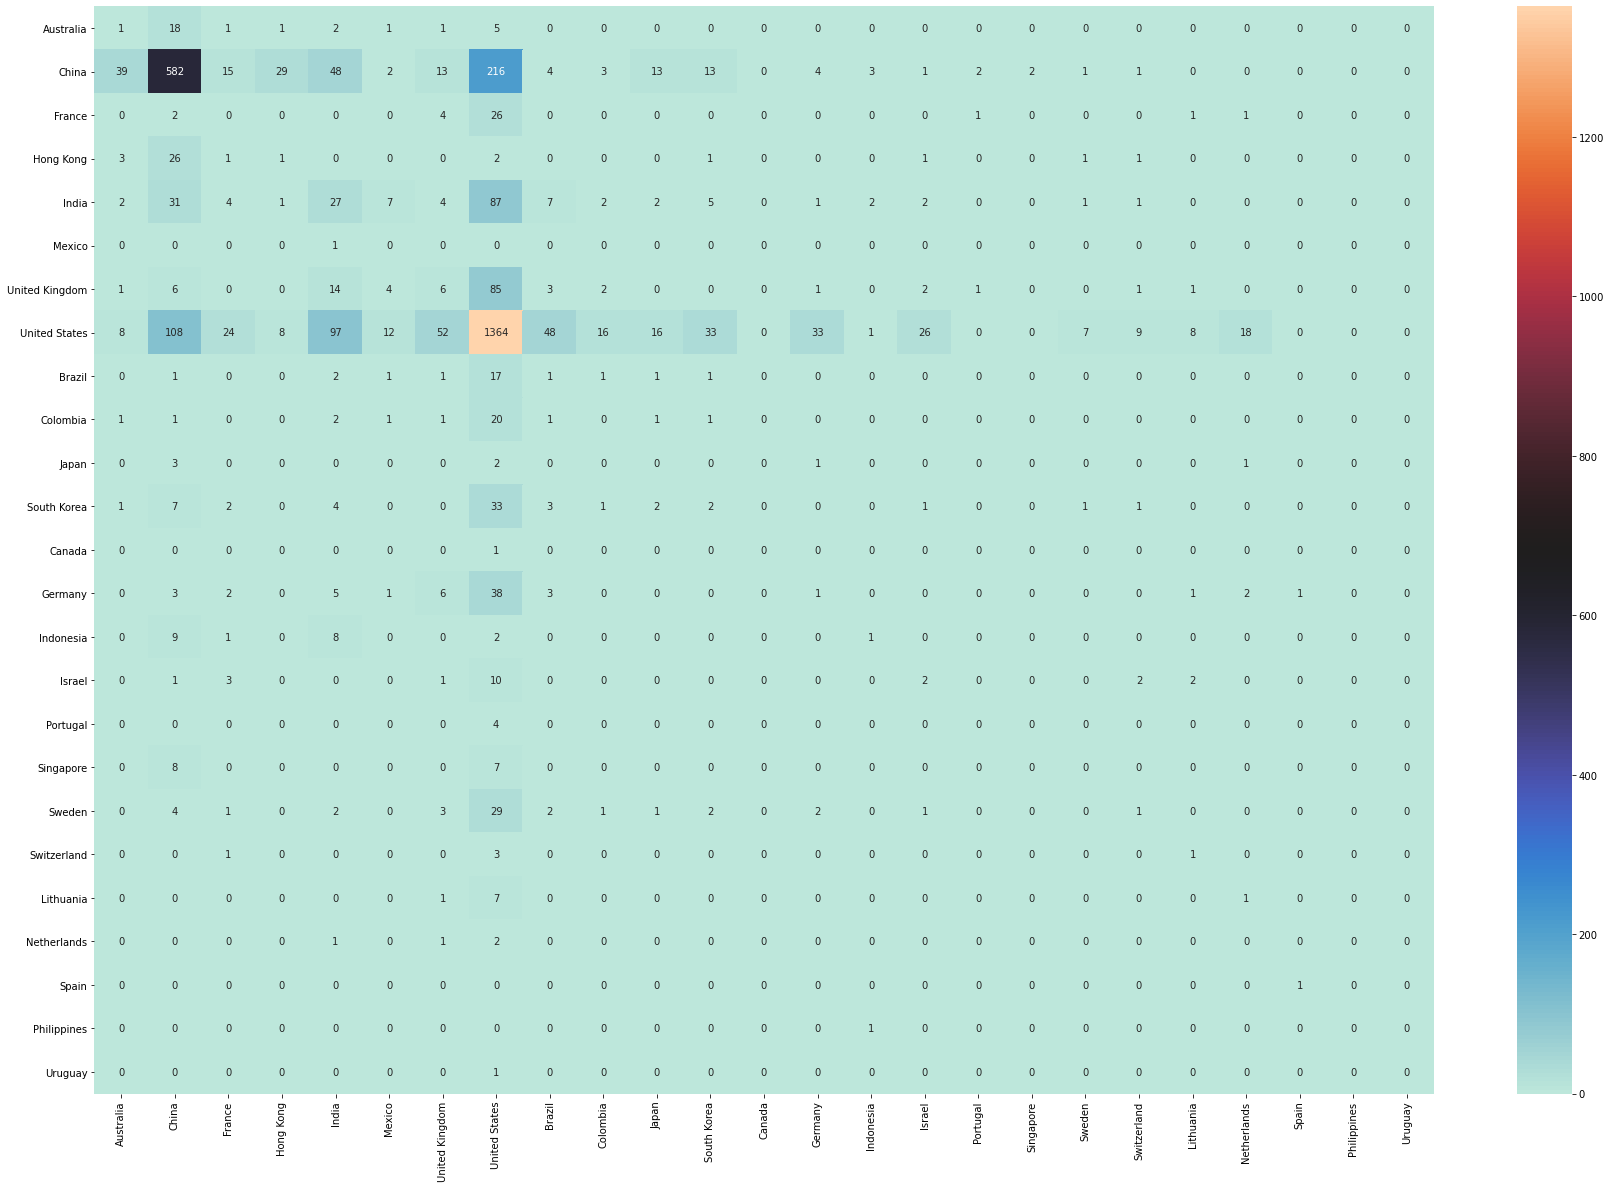

In [74]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
plt.figure(figsize=(30, 20))
center = (country_dgraph_matrix.max().max() - country_dgraph_matrix.min().min()) / 2
sns.heatmap(country_dgraph_matrix, center=center, annot=True, fmt=".0f") # , annot_kws={"fontsize":3}
plt.savefig(os.path.join("..", "out", "adjacency", "country_dgraph.png"))
country_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_dgraph.csv"))

In [75]:
industry_dgraph_df = country_industry_df.groupby(by=["Industry_source", "Industry_target"], as_index=False).agg({"source": 'count'})
industry_dgraph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,20
1,Artificial intelligence,Auto & transportation,12
2,Artificial intelligence,Consumer & retail,7
3,Artificial intelligence,Cybersecurity,6
4,Artificial intelligence,Data management & analytics,16


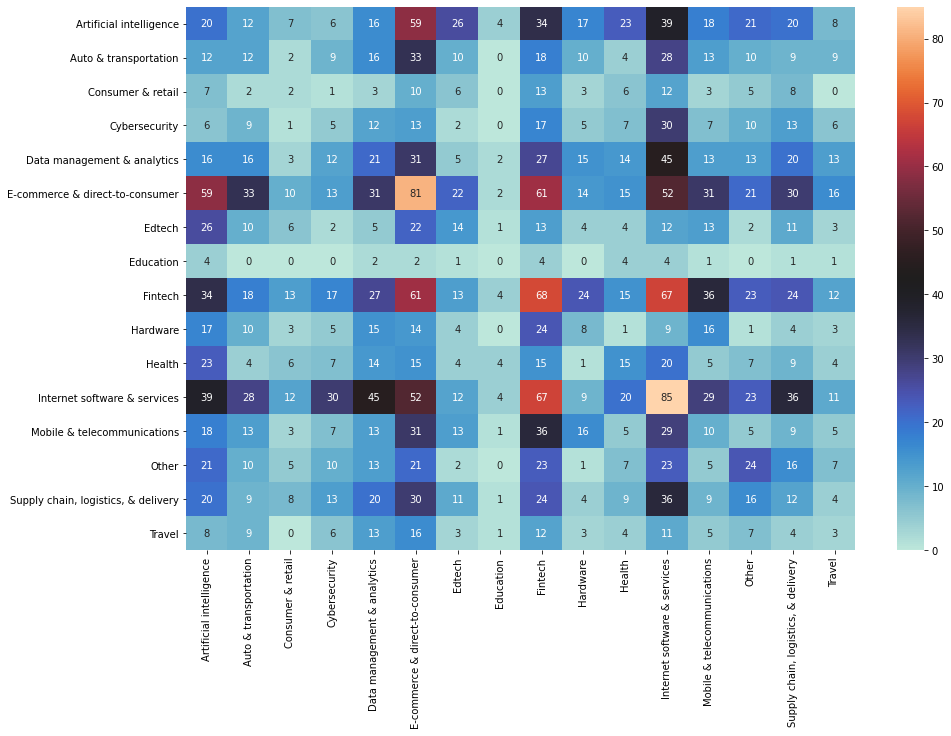

In [76]:
plt.figure(figsize=(15, 10))
center = (industry_graph_matrix.max().max() - industry_graph_matrix.min().min()) / 2
sns.heatmap(industry_graph_matrix, center=center, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_graph.png"))

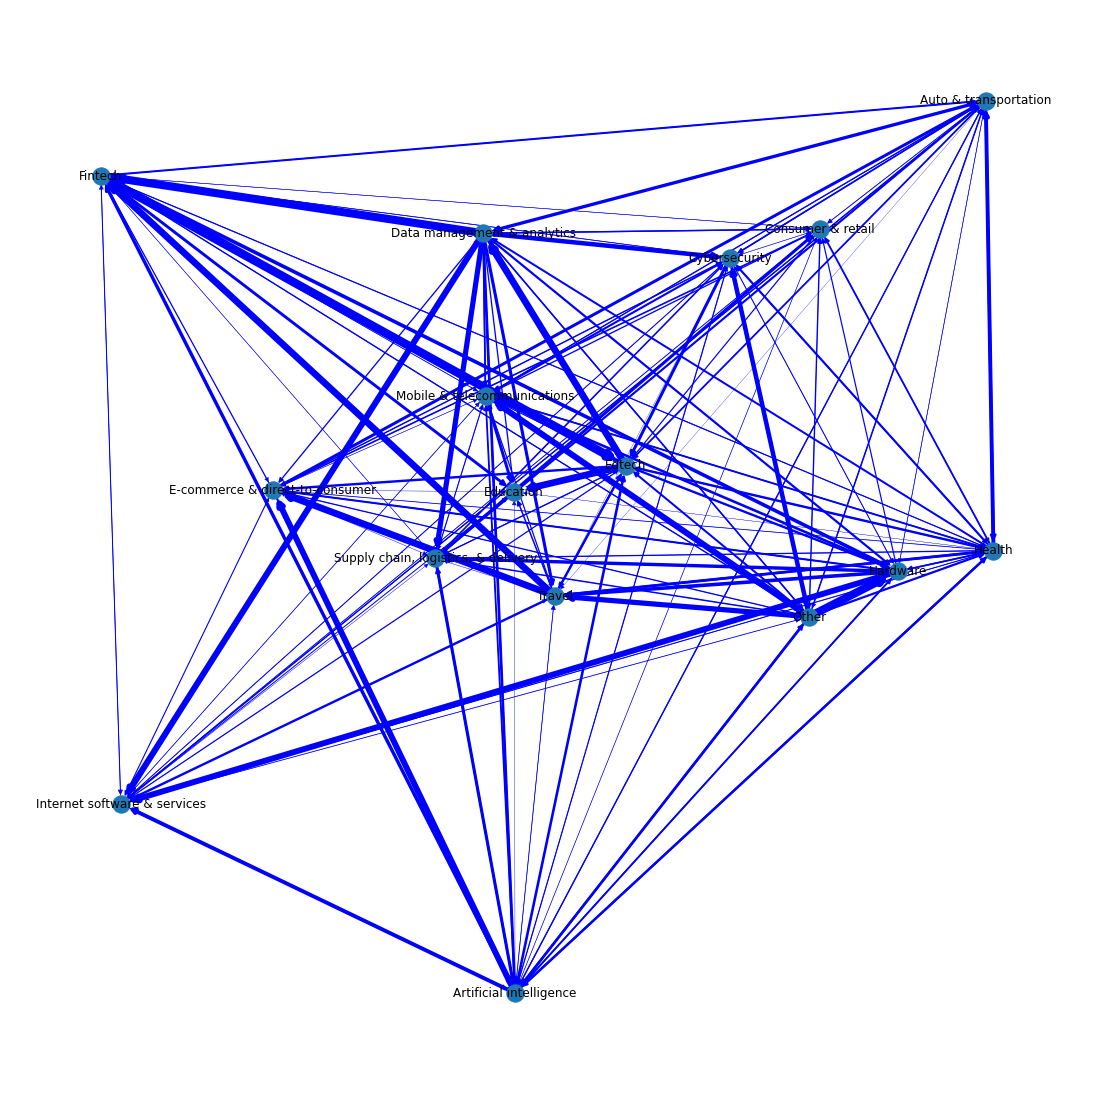

In [77]:
industry_DG = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "industry_dgraph.png"))
industry_dgraph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_dgraph.csv"), sep="\t")

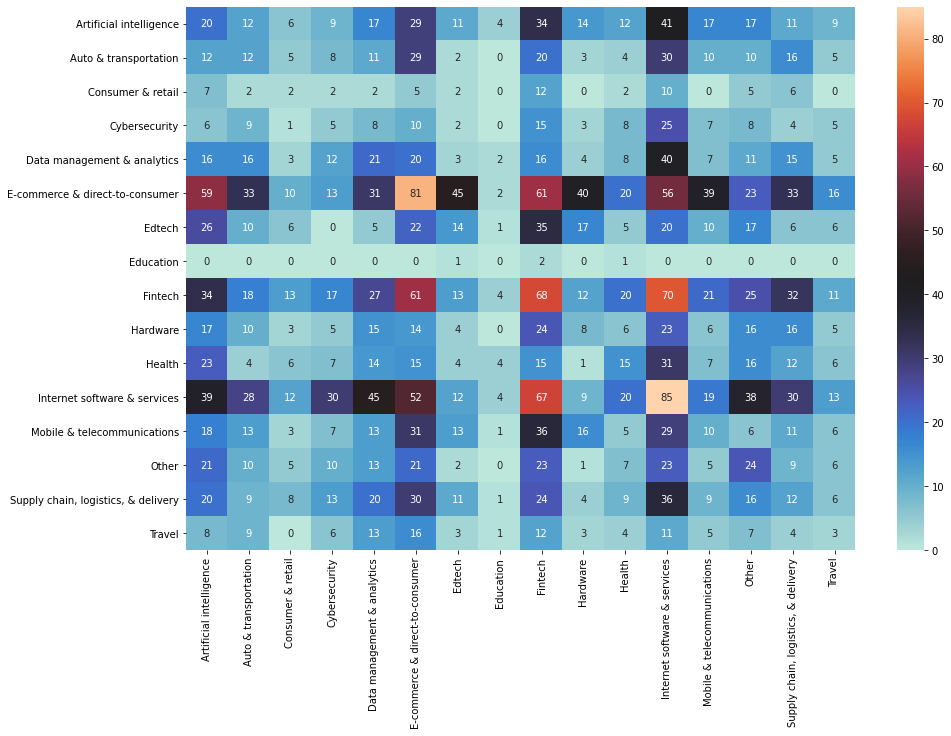

In [78]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
plt.figure(figsize=(15, 10))
center = (industry_dgraph_matrix.max().max() - industry_dgraph_matrix.min().min()) / 2
sns.heatmap(industry_dgraph_matrix, center=center, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_dgraph.png"))
industry_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_dgraph.csv"))

In [79]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [80]:
country_centrality_df.to_csv(os.path.join("..", "out", "features", "country_unicorn_centrality.csv"))

In [81]:
industry_centrality_df.to_csv(os.path.join("..", "out", "features", "industry_unicorn_centrality.csv"))

# 回帰分析

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [83]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Meero,0.007126,0.000386,2.550019e-34,0.032960,0.001649,0.004751,0.002375,4,7,1.0,...,0.003555,0.0,$1,6/18/2019,France,Artificial intelligence,"[Aglae Ventures, Global Founders Capital, Al...",1.0,2019-06-18,1.0
Dataiku,0.021378,0.000334,6.998816e-24,0.101094,0.002563,0.016627,0.004751,3,6,1.0,...,0.010664,0.0,$1.40,12/4/2019,United States,Internet software & services,"[Alven Capital, FirstMark Capital, capitalG]",1.4,2019-12-04,1.4
Away,0.019002,0.000752,1.026045e-35,0.042234,0.001719,0.011876,0.007126,5,15,1.0,...,0.009479,0.0,$1.40,5/15/2019,United States,E-commerce & direct-to-consumer,"[Global Founders Capital, Comcast Ventures, ...",1.4,2019-05-15,1.4
Traveloka,0.004751,0.000000,2.250281e-59,0.000000,0.000815,0.000000,0.004751,5,16,1.0,...,0.002370,0.0,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.0,2017-01-01,3.0
Kuaishou,0.073634,0.002263,1.057246e-48,0.014868,0.000923,0.011876,0.061758,6,270,1.0,...,0.036730,0.0,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.0,2015-01-01,18.0


In [84]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation($B)', 'Date Joined', 'Country',
       'Industry', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [85]:
train_df = unicorn_data_df.drop([
    'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Meero,0.002375,7,1.0
Dataiku,0.004751,6,1.4
Away,0.007126,15,1.4
Traveloka,0.004751,16,3.0
Kuaishou,0.061758,270,18.0


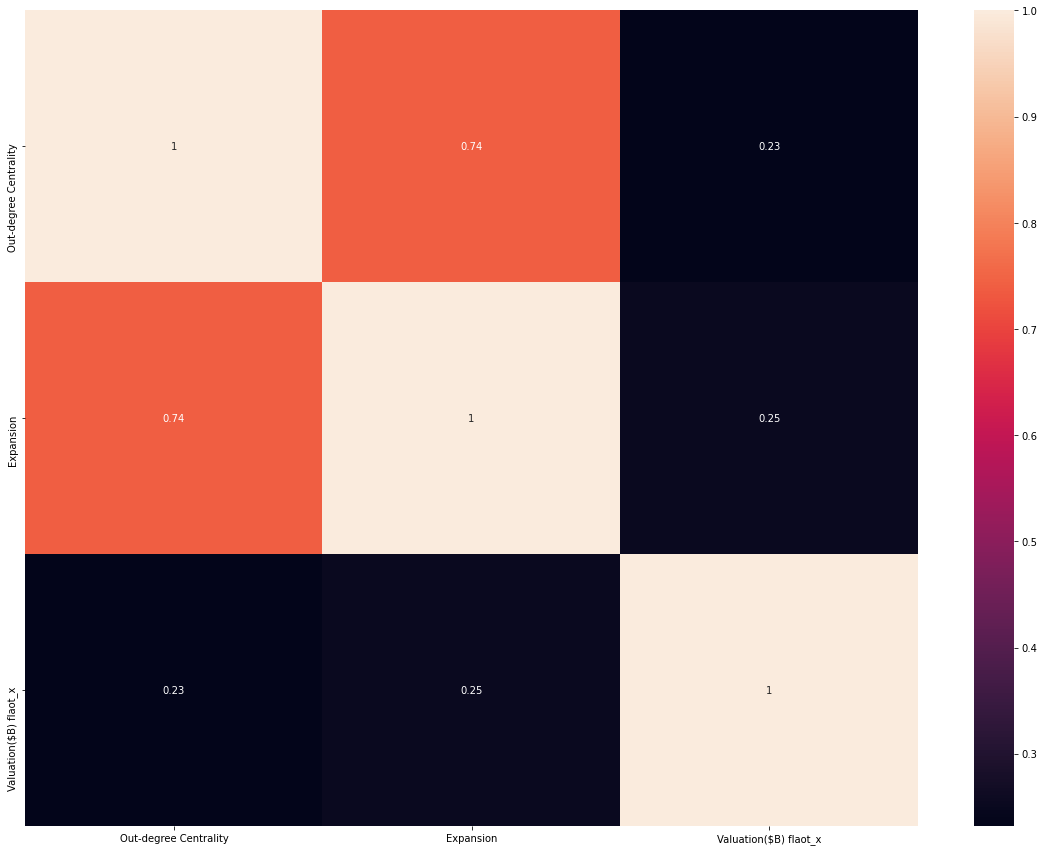

In [86]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [87]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [88]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Valuation($B) flaot_x   R-squared:                       0.068
Model:                               OLS   Adj. R-squared:                  0.064
Method:                    Least Squares   F-statistic:                     15.37
Date:                   Fri, 30 Apr 2021   Prob (F-statistic):           3.63e-07
Time:                           11:09:51   Log-Likelihood:                -583.86
No. Observations:                    422   AIC:                             1174.
Df Residuals:                        419   BIC:                             1186.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.469e-18      0.047  -7.36e-17      1.000      -0.093       0.093
Out-degree Centrality     0.0991      0.070      1.412      0.159      -0.039       0.237
Expansion                 0.1794      0.070      2.556      0.011       0.041       0.317
==============================================================================
Omnibus:                      792.853   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           600350.519
Skew:                          12.009   Prob(JB):                         0.00
Kurtosis:                     186.211   Cond. No.                         2.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Out-degree Centrality,1.000000,0.740652,0.231973
Expansion,0.740652,1.000000,0.252793
Valuation($B) flaot_x,0.231973,0.252793,1.000000


In [90]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion                0.0
dtype: float64

In [91]:
with open(os.path.join("..", "out", "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [92]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,IDG Capital,0.043027,0.001682,4.958935e-14,0.028142,0.002494,0.013353,0.029674,6,70,1.0,0.0,0.021481,0.0,63.68,17,3.745882,3,8,17
1,Star VC,0.004451,0.000000,1.315948e-12,0.020473,0.001011,0.002967,0.001484,1,1,1.0,0.0,0.002222,0.0,7.50,1,7.500000,1,1,1
2,Infore Capital,0.004451,0.000000,3.345124e-11,0.021277,0.001869,0.004451,0.000000,0,0,1.0,0.0,0.002222,0.0,7.50,1,7.500000,1,1,1
3,Alibaba Group,0.032641,0.000622,1.291628e-26,0.004276,0.000956,0.001484,0.031157,6,245,1.0,0.0,0.016296,0.0,54.15,12,4.512500,4,10,12
4,Ribbit Capital,0.013353,0.000751,7.448808e-06,0.037455,0.002696,0.007418,0.005935,2,7,1.0,0.0,0.006667,0.0,12.70,5,2.540000,2,1,5


In [93]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,675.000000,675.000000,6.750000e+02,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.0,675.0,675.000000,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.005451,0.000138,1.745878e-03,0.011705,0.001481,0.002726,0.002726,1.451852,25.500741,1.0,0.0,0.002722,0.0,6.851896,2.022222,2.959295,1.257778,1.644444,2.022222
std,0.007363,0.000600,3.847892e-02,0.010920,0.000606,0.002413,0.006078,2.192916,79.498043,0.0,0.0,0.003676,0.0,18.237397,2.981811,7.060772,0.823565,1.617168,2.981811
min,0.001484,0.000000,2.632173e-35,0.000000,0.000866,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000741,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.002967,0.000000,8.607207e-33,0.001484,0.000981,0.001484,0.000000,0.000000,0.000000,1.0,0.0,0.001481,0.0,1.085000,1.000000,1.037500,1.000000,1.000000,1.000000
50%,0.002967,0.000000,2.173141e-21,0.009206,0.001263,0.002967,0.001484,1.000000,1.000000,1.0,0.0,0.001481,0.0,2.000000,1.000000,1.600000,1.000000,1.000000,1.000000
75%,0.004451,0.000000,6.955380e-10,0.019811,0.001810,0.002967,0.002967,1.000000,2.000000,1.0,0.0,0.002222,0.0,4.450000,2.000000,2.666667,1.000000,2.000000,2.000000
max,0.065282,0.010152,9.951116e-01,0.051613,0.004264,0.017804,0.053412,11.000000,433.000000,1.0,0.0,0.032593,0.0,225.280000,28.000000,140.000000,9.000000,13.000000,28.000000


In [94]:
investor_data_df = investor_data_df.set_index("Investor")

In [95]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,675.000000,675.000000,675.000000,675.000000
mean,0.000138,25.500741,2.022222,6.851896
std,0.000600,79.498043,2.981811,18.237397
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.085000
50%,0.000000,1.000000,1.000000,2.000000
75%,0.000000,2.000000,2.000000,4.450000
max,0.010152,433.000000,28.000000,225.280000


In [96]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [97]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.531
Model:                             OLS   Adj. R-squared:                  0.529
Method:                  Least Squares   F-statistic:                     253.0
Date:                 Fri, 30 Apr 2021   Prob (F-statistic):          8.45e-110
Time:                         11:09:51   Log-Likelihood:                -702.41
No. Observations:                  675   AIC:                             1413.
Df Residuals:                      671   BIC:                             1431.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.429e-17      0.026   9.18e-16      1.000      -0.052       0.052
Betweenness Centrality     0.1947      0.043      4.570      0.000       0.111       0.278
Expansion                  0.1363      0.032      4.201      0.000       0.073       0.200
#unicorns                  0.4811      0.048     10.081      0.000       0.387       0.575
==============================================================================
Omnibus:                      931.862   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           182280.485
Skew:                           7.313   Prob(JB):                         0.00
Kurtosis:                      82.165   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [99]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality    0.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [100]:
with open(os.path.join("..", "out", "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())